In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
import matplotlib.pyplot as plt

In [3]:
import braindecode
import eegdash
import matplotlib.pyplot as plt

In [4]:
from pathlib import Path
from eegdash.dataset import EEGChallengeDataset

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

dataset_ccd = EEGChallengeDataset(task="contrastChangeDetection",
                                  release="R5", cache_dir=DATA_DIR,
                                  mini=True)



╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=665527;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=909468;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

Using matplotlib as 2D backend.


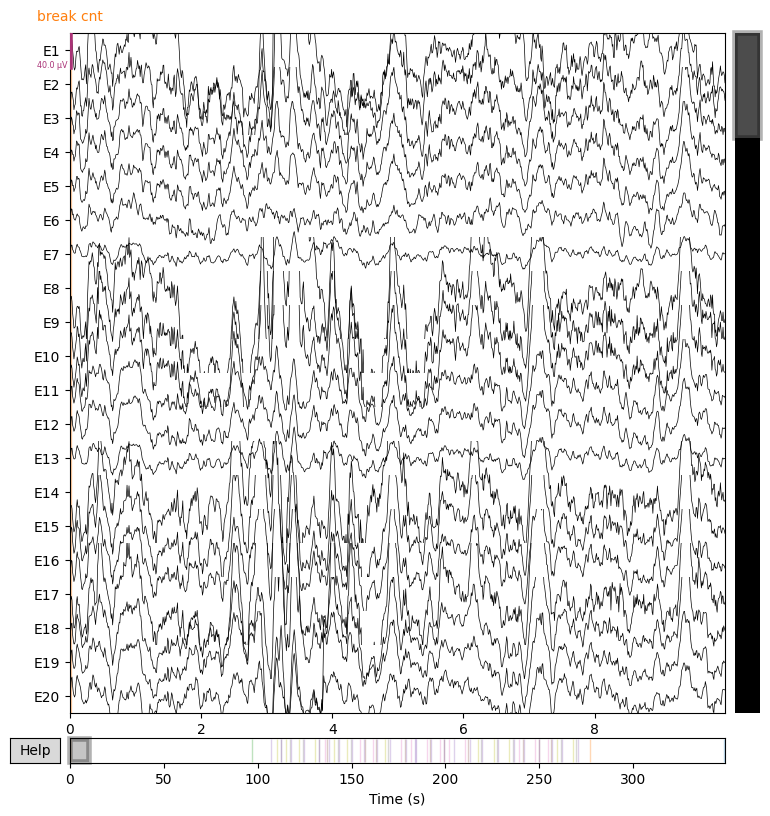

In [5]:
raw = dataset_ccd.datasets[0].raw
fig = raw.plot()

In [6]:
raw 

<RawEDF | sub-NDARAH793FBF_task-contrastChangeDetection_run-1_eeg.bdf, 129 x 34900 (349.0 s), ~125 KiB, data not loaded>

## 2. Creating the windows of interest

Now that we have our raw dataset, defining the windows/epoch interval is essential.

For this challenge, we test many different and semantically different regions of interest, and our preliminary studies show us that the most interesting area of interest is defined below:


*        stimulus         │        response         │        feedback
*                         │ *********************** (stimulus + 0.5)

So we epoch after the stimulus moment with a beginning shift of 500 ms

In [7]:
#@title ▶️ Run this first to get all the utils functions for the epoching
from braindecode.datasets import BaseConcatDataset

We fit events present in it and create a window of interest

In [8]:
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,
    keep_only_recordings_with,
)

# Short 2 seconds clip 
EPOCH_LEN_S = 2.0
SFREQ = 100     # By definition here 


transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field = "rt_from_stimulus",
        epoch_length = EPOCH_LEN_S,
        require_stimulus=True, require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs = -1)

Basic info about the dataset

In [9]:
first_instance = dataset_ccd.datasets[0]
first_instance

In [10]:
ANCHOR = "stimulus_anchor"

# "Don't start the clip exactly at the anchor. I want to wait 0.5 seconds after the stimulus."
SHIFT_AFTER_STIM = 0.5

# Cut into 2 seconds clip
WINDOW_LEN       = 2.0

# Keep only recordings that actually contain stimulus anchors
dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

# Create single-interval windows (stim-locked, long enough to include the response)
single_windows = create_windows_from_events(
    dataset, 
    mapping = {ANCHOR: 0},
    trial_start_offset_samples = int(SHIFT_AFTER_STIM * SFREQ),
    trial_stop_offset_samples = int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),
    window_size_samples = int(EPOCH_LEN_S * SFREQ),
    window_stride_samples = SFREQ,
    preload = True,
)

# Injecting metadata into the extra mne annotation
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc = ANCHOR,
    keys = ("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
)

Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_(

`create_windows_from_events`: This means the code does something very simple: For every 'stimulus_anchor' bookmark, it cuts exactly one 2-second clip, which captures the EEG data from 0.5 seconds to 2.5 seconds after the stimulus.

Meaning of `add_extras_columns`: Go back to the original, fully-bookmarked data (dataset). For every single 2-second clip you just cut, find the original 'stimulus_anchor' it came from. Then, find all the other bookmarks associated with that anchor and copy them over to the clip's metadata.

Now that we have our windowed data, we can split it into the different sets that are needed for modeling. Since our challenge focuses on generalization across subjects, we recommend dividing at the subject level.

(1) the training set is used to learn the parameters of our deep learning model,  

(2) the validation set is used to monitor the training process and decide when to stop it, and  

(3) the test set is used to provide an estimate of the generalization performance of our model.

Here, we use the last 10% of windows for testing, 10% for validation and split the remaining 80% of windows into training.

**Here we go into the steps that you and your team must validate to obtain better results**

In [11]:
meta_information = single_windows.get_metadata()
meta_information.head()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,...,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,0,11056,11256,2.11,2.11,4.932,110.062,112.172,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
1,0,11579,11779,1.87,1.87,4.672,115.29,117.16,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
2,0,12259,12459,1.95,1.95,6.35,122.09,124.04,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
3,0,13099,13299,2.1,2.1,8.1,130.49,132.59,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
4,0,13619,13819,1.22,1.22,4.02,135.69,136.91,1,left_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available


In [12]:
# Get the 'spreadsheet' of all your trials
df = single_windows.description
df.head()

,subject,run,task,age,sex,release_number,ehq_total,commercial_use,full_pheno,p_factor,...,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,NDARAH793FBF,1,contrastChangeDetection,9.3427,M,R5,60.03,Yes,No,0.317,...,available,available,available,available,available,available,available,unavailable,available,available
1,NDARAH793FBF,2,contrastChangeDetection,9.3427,M,R5,60.03,Yes,No,0.317,...,available,available,available,available,available,available,available,unavailable,available,available
2,NDARAH793FBF,3,contrastChangeDetection,9.3427,M,R5,60.03,Yes,No,0.317,...,available,available,available,available,available,available,available,unavailable,available,available
3,NDARAJ689BVN,2,contrastChangeDetection,5.4878,F,R5,46.69,Yes,No,0.084,...,available,available,available,available,available,available,available,available,unavailable,available
4,NDARAJ689BVN,1,contrastChangeDetection,5.4878,F,R5,46.69,Yes,No,0.084,...,available,available,available,available,available,available,available,available,unavailable,available


In [16]:
df.columns

Index(['subject', 'run', 'task', 'age', 'sex', 'release_number', 'ehq_total',
       'commercial_use', 'full_pheno', 'p_factor', 'attention',
       'internalizing', 'externalizing', 'restingstate', 'despicableme',
       'funwithfractals', 'thepresent', 'diaryofawimpykid',
       'contrastchangedetection_1', 'contrastchangedetection_2',
       'contrastchangedetection_3', 'surroundsupp_1', 'surroundsupp_2',
       'seqlearning6target', 'seqlearning8target', 'symbolsearch'],
      dtype='object')

In [17]:
meta_information.columns

Index(['i_window_in_trial', 'i_start_in_trial', 'i_stop_in_trial', 'target',
       'rt_from_stimulus', 'rt_from_trialstart', 'stimulus_onset',
       'response_onset', 'correct', 'response_type', 'subject', 'run', 'task',
       'age', 'sex', 'release_number', 'ehq_total', 'commercial_use',
       'full_pheno', 'p_factor', 'attention', 'internalizing', 'externalizing',
       'restingstate', 'despicableme', 'funwithfractals', 'thepresent',
       'diaryofawimpykid', 'contrastchangedetection_1',
       'contrastchangedetection_2', 'contrastchangedetection_3',
       'surroundsupp_1', 'surroundsupp_2', 'seqlearning6target',
       'seqlearning8target', 'symbolsearch'],
      dtype='object')

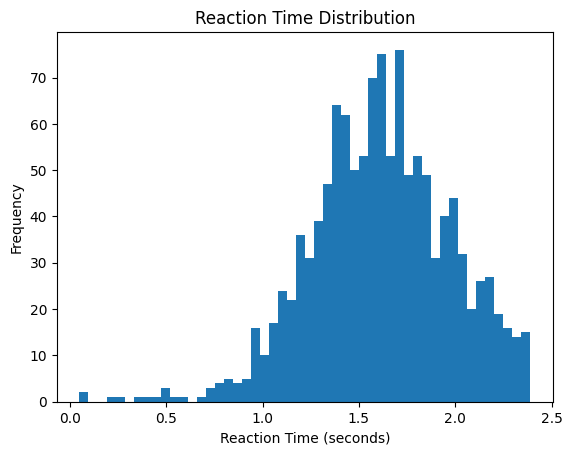

count      1214.0
mean     1.613932
std      0.362527
min          0.05
25%          1.38
50%          1.62
75%        1.8565
max          2.39
Name: rt_from_stimulus, dtype: Float64


In [18]:
# Plot a histogram of all reaction times
meta_information['rt_from_stimulus'].plot(kind='hist', bins=50, title='Reaction Time Distribution')
plt.xlabel('Reaction Time (seconds)')
plt.show()

# Get the exact numbers (min, max, mean)
print(meta_information['rt_from_stimulus'].describe())

### Inspect the target label doing

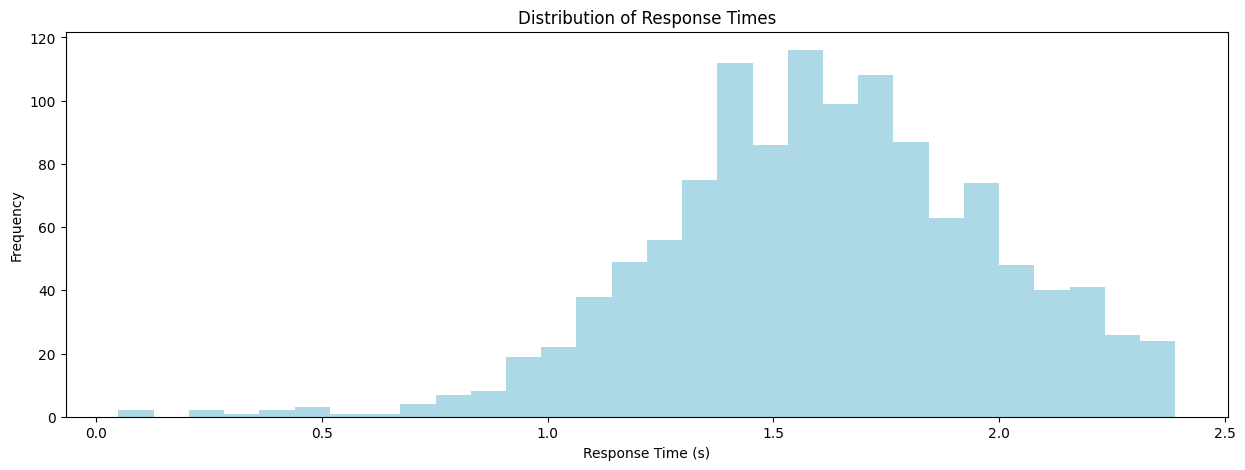

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = meta_information["target"].plot.hist(bins=30, ax=ax, color='lightblue')
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Response Times")
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

valid_frac = 0.1
test_frac = 0.1
seed = 2025

subjects = meta_information["subject"].unique()
sub_rm = ["NDARWV769JM7", "NDARME789TD2", "NDARUA442ZVF", "NDARJP304NK1",
          "NDARTY128YLU", "NDARDW550GU6", "NDARLD243KRE", "NDARUJ292JXV", "NDARBA381JGH"]
subjects = [s for s in subjects if s not in sub_rm]

train_sub, val_test_sub = train_test_split(
    subjects, test_size = (valid_frac + test_frac), random_state=check_random_state(seed)
)

val_sub, test_sub = train_test_split(
    val_test_sub, test_size = test_frac, random_state=check_random_state(seed + 1)
)

assert (set(val_sub) | set(test_sub) | set(train_sub)) == set(subjects)

In [23]:
print("Length of train_sub", len(train_sub))
print("Length of val_sub", len(val_sub))
print("Length of test_sub", len(test_sub))

Length of train_sub 16
Length of val_sub 3
Length of test_sub 1


In [24]:
len(subjects)

20

In [29]:
subject_split = single_windows.split("subject")

train_set = []
valid_set = []
test_set = []

for s in subject_split:
    if s in train_sub:
        print(s)
        train_set.append(subject_split[s])
    elif s in val_sub:
        valid_set.append(subject_split[s])
    elif s in test_sub:
        test_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
valid_set = BaseConcatDataset(valid_set)
test_set = BaseConcatDataset(test_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Valid:\t{len(valid_set)}")
print(f"Test:\t{len(test_set)}")

NDARAH793FBF
NDARAJ689BVN
NDARAU708TL8
NDARBE091BGD
NDARBE103DHM
NDARBF851NH6
NDARBH228RDW
NDARBJ674TVU
NDARBM433VER
NDARCA740UC8
NDARCU736GZ1
NDARCU744XWL
NDARDH086ZKK
NDARDL305BT8
NDARDV245WJG
NDAREC480KFA
Number of examples in each split in the minirelease
Train:	981
Valid:	183
Test:	50


#### EDA 1: Analyze This Subject's Behavior

In [65]:
import seaborn as sns

subjectid = "NDARAH793FBF"

# Get the dataset object for just this one subject
subject_data = subject_split[subjectid]
meta_df = subject_data.get_metadata().reset_index(drop=True)

meta_df.head()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,...,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,0,11056,11256,2.11,2.11,4.932,110.062,112.172,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
1,0,11579,11779,1.87,1.87,4.672,115.29,117.16,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
2,0,12259,12459,1.95,1.95,6.35,122.09,124.04,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
3,0,13099,13299,2.1,2.1,8.1,130.49,132.59,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
4,0,13619,13819,1.22,1.22,4.02,135.69,136.91,1,left_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available


What it tells you: How fast was this person on average? Were they consistent, or were their reaction times all over the place?

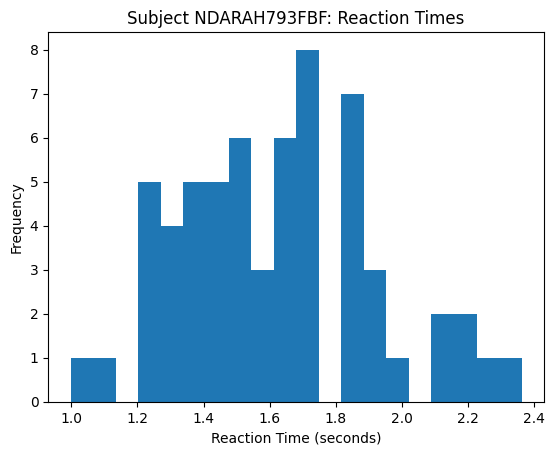

count        61.0
mean     1.624852
std      0.292468
min         0.998
25%          1.39
50%         1.628
75%         1.852
max         2.362
Name: rt_from_stimulus, dtype: Float64


In [67]:

correct_trials = meta_df[meta_df["correct"] == True]
correct_trials['rt_from_stimulus'].plot(kind='hist', bins=20, 
                                         title=f"Subject NDARAH793FBF: Reaction Times")

plt.xlabel('Reaction Time (seconds)')
plt.show()

# Get their personal stats
print(correct_trials['rt_from_stimulus'].describe())

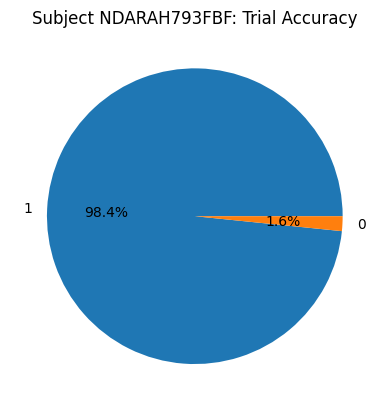

In [68]:
# Plot a pie chart of their correct vs. incorrect trials
meta_df['correct'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                      title=f"Subject NDARAH793FBF: Trial Accuracy")
plt.ylabel('') # Hide the 'correct' label
plt.show()

Created a data stack with shape: (61, 129, 200)
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Successfully loaded 61 correct epochs for this subject.
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/tmp/ipykernel_6539/200680015.py:25: UserWarning: Zero value in spectrum for channel Cz
  correct_mne_epochs.compute_psd(fmax=50).plot()
/tmp/ipykernel_6539/200680015.py:25: UserWarning: Infinite value in PSD for channel Cz.
These channels might be dead.
  correct_mne_epochs.compute_psd(fmax=50).plot()
/tmp/ipykernel_6539/200680015.py:25: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  correct_mne_epochs.compute_psd(fmax=50).plot()


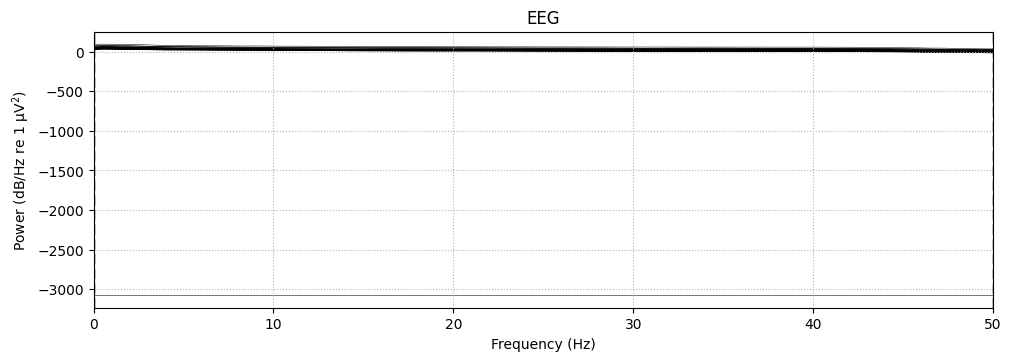

In [104]:
# 1. Get the channel/sfreq info from the *original* raw dataset.
# This is guaranteed to be correct and accessible.
info = dataset_ccd.datasets[0].raw.info

# 2. Get the clean indices for correct trials
correct_epoch_indices = meta_df[meta_df['correct'] == True].index.tolist()

# 3. Loop through the subject's data and get the raw data (X) for *only*
# the correct trials. subject_data[i] returns (X, y, metadata_row)
correct_epochs_data = [subject_data[i][0] for i in correct_epoch_indices]

# 4. Stack all the 2D trial arrays into a single 3D numpy array
# The shape will be (n_trials, n_channels, n_samples)
stacked_epochs_data = np.stack(correct_epochs_data)

print(f"Created a data stack with shape: {stacked_epochs_data.shape}")

# 5. Create a new mne.EpochsArray object from our data
# This gives us a fresh MNE object to plot with.
# We set tmin=0.5 because your clips start 0.5s after the stimulus.
correct_mne_epochs = mne.EpochsArray(stacked_epochs_data, info, tmin=SHIFT_AFTER_STIM)

# 6. Now, plot the PSD (This will work!)
print(f"Successfully loaded {len(correct_mne_epochs)} correct epochs for this subject.")
correct_mne_epochs.compute_psd(fmax=50).plot()
# plt.show()

In [110]:
correct_mne_epochs[0]

<EpochsArray | 1 events (all good), 0.5 – 2.49 s (baseline off), ~333 KiB, data loaded,
 '1': 1>

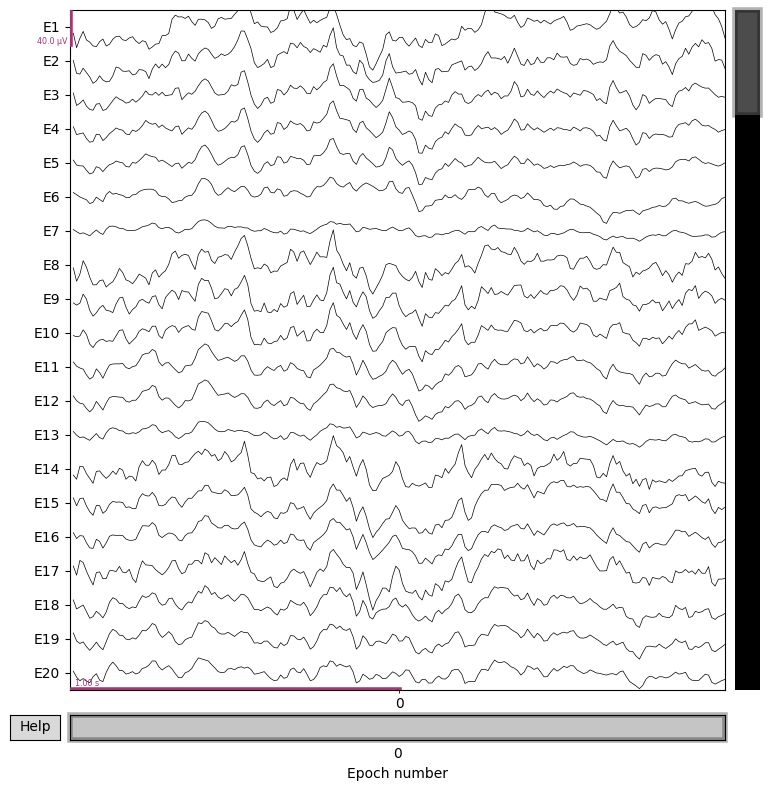

In [108]:
correct_mne_epochs[0].plot()
plt.show()

### Let see what does the train set has

In [113]:
X, y, z= train_set[0]

In [114]:
X.shape

(129, 200)

In [116]:
y.shape

(1,)

In [117]:
z

[0, 11056, 11256]